# Pre BackTest repaso curso introductorio

## Función para traer datos

### Para traer un solo ticker por vez

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
def getData(symbol, start='2000-01-01', interval='1d', end=None):
    data = yf.download(symbol, start=start, end=end, interval=interval, auto_adjust=True)
    return data

### Para traer multiples tickers, batch requests etc

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands Inc,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet Holdings,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [4]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [t for t in sp500_tickers if t not in ['BRK.B' ,'BF.B']]

In [5]:
def getDataM(listado, start='2000-01-01', interval='1d', end=None):
    data = yf.download(listado, start=start, end=end, interval=interval, auto_adjust=True)
    return data.swaplevel(i=1, j=0, axis=1)

In [6]:
df_sp500 = getDataM(sp500_tickers)

[*********************100%***********************]  503 of 503 downloaded


In [7]:
df_sp500['AAPL']

,Close,High,Low,Open,Volume
Date,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN
2000-01-03,3.45,3.47,3.14,3.24,133949200.0
2000-01-04,3.16,3.41,3.12,3.34,128094400.0
2000-01-05,3.21,3.41,3.18,3.20,194580400.0
2000-01-06,2.93,3.30,2.93,3.28,191993200.0
...,...,...,...,...,...
2020-08-13,460.04,464.17,455.71,457.72,52520500.0
2020-08-14,459.63,460.00,452.18,459.32,41391300.0
2020-08-17,458.43,464.35,455.85,464.25,29890400.0


## Función para crear señales

In [8]:
def addSignal(data, fast=5, slow=20, rsi_q=14, buy_cr=1, buy_rsi=60, sell_cr=0.98, sell_rsi=35):
    
    data['Cruce'] = (data.Close.rolling(fast).mean() / data.Close.rolling(slow).mean() -1)*100
    
    dif = data['Close'].diff()
    win =  pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1/rsi_q).mean()
    ema_loss = loss.ewm(alpha=1/rsi_q).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1+rs))
    rsi.index = data.index
    data['rsi'] = rsi

    data['Señal'] = 'Sin Señal'
    comprar = (data.Cruce > buy_cr) & (data.rsi > buy_rsi)
    data.loc[comprar, 'Señal'] = 'Compra'

    vender = (data.Cruce < sell_cr) & (data.rsi < sell_rsi)
    data.loc[vender, 'Señal'] = 'Venta'
    
    return data

## Función para armar tabla de Trades

In [9]:
def getTrades(data):
    
    # Una sola entrada y salida por vez
    trades = data.loc[data.Señal != 'Sin Señal'].copy()
    trades['Señal'] = np.where(trades.Señal != trades.Señal.shift(), trades.Señal,'Sin Señal')
    trades = trades.loc[trades.Señal != 'Sin Señal'].copy()

    try:
        # Supuesto estrategia long, debe empezar con compra y terminar con venta
        if trades.iloc[0,7]=='Venta':
            trades = trades.iloc[1:]

        if trades.iloc[-1,7]=='Compra':
            trades = trades.iloc[:-1]
    except:
        pass
    
    return(trades)

## Funciones de reporting

In [10]:
def getYields(trades):
    precios_compra = trades.iloc[::2].reset_index().Close
    precios_venta = trades.iloc[1::2].reset_index().Close

    fechas_compra = trades.iloc[::2].index
    fechas_venta = trades.iloc[1::2].index
    
    yields = (precios_venta/precios_compra-1).to_frame()
    yields.columns = ['yield']
    yields['days'] = (fechas_venta - fechas_compra).days
    yields['ok'] = np.where(yields['yield'] > 0,True,False)
    yields['yield_cum'] = (yields['yield']+1).cumprod()
    
    return yields

## Uso de todo esto

In [11]:
data = getData('AAPL')
df = addSignal(data,fast=5, slow=20, rsi_q=14, buy_cr=1, buy_rsi=70, sell_cr=0.98, sell_rsi=35)
trades = getTrades(df)
yields = getYields(trades)
resultado = float((yields.iloc[-1:].yield_cum-1)*100)

[*********************100%***********************]  1 of 1 downloaded


In [12]:
trades.head()

,Open,High,Low,Close,Volume,Cruce,rsi,Señal
Date,,,,,,,,
2000-08-30,3.64,3.70,3.62,3.67,71348200,13.280507,70.171919,Compra
2000-09-29,1.74,1.79,1.57,1.59,1855410200,-16.419645,23.825804,Venta
2001-12-05,1.38,1.48,1.37,1.47,142144800,7.821901,74.907371,Compra
2002-06-07,1.34,1.35,1.29,1.32,153094200,-6.241520,32.875966,Venta
2002-11-04,1.02,1.07,1.01,1.04,94204600,7.733910,71.928803,Compra


In [13]:
yields.head()

,yield,days,ok,yield_cum
0,-0.566757,30,False,0.433243
1,-0.102041,184,False,0.389034
2,-0.221154,158,False,0.302998
3,0.272727,197,True,0.385633
4,2.194444,462,True,1.231885


In [14]:
resultado

2089.024403595871

In [15]:
agg_q = yields.groupby('ok').size()
agg_q

ok
False     8
True     17
dtype: int64

In [16]:
agg_y = yields.groupby('ok').mean()['yield']
agg_y

ok
False   -0.133847
True     0.369802
Name: yield, dtype: float64

In [17]:
agg_t = yields.groupby('ok').sum()['days']
agg_t

ok
False     701
True     3612
Name: days, dtype: int64

## Esperanza matemática

In [18]:
E = agg_q[True] * agg_y[True] + agg_q[False] * agg_y[False]
E

5.215854646327621

## % de Tiempo comprado

In [19]:
time_in = agg_t[True] / (agg_t[True] + agg_t[False]) 
time_in

0.8374681196383028

# Contenidos de un backtest

* PreBackTest
    * Análisis de correlación
    * Trades con una determinada parametrizacion en un determinado activo
    * Tabla de resultados o reporting básico
        * % de trades positivos y negativos
        * Esperanza matemática del método
        * Tiempo comprado / libre
        
        
* Backtest básico
    * Trades en un grupo de activos, en un rango de parametros
    * Tabla de resultados intermedia
        * Resultados año a año
        * Comparación con el buy&Hold
        * Comparación con el banchmark
        * Ratios de riesgo (Sharpe, Sortino, etc)
        
        
* Análisis de sensibilidad
    * Parametrización de variables
    * Cambio de indicadores/ideas como grupo de control
    
    
* Backtest Avanzado
    * Manejo de posición/riesgo, exposición óptima (Kelly, Montecarlo etc)
    * Riesgo de overfiting
    * Factibilidad técnica (volúmenes, liquidez, spreads, fallas, tiempos etc)

    
* Análisis de portabilidad
    * Cruce y armado de matrices de resultados
    * Matrices de correlacion cross mkt
    * Matrices de correlacion cross time-frame
    * Clusterizacion por régimenes (volatilidad, épocas, ciclos etc)

# Analisis de sensibilidad básico

## Sensibilidad del "q" del RSI

[*********************100%***********************]  1 of 1 downloaded


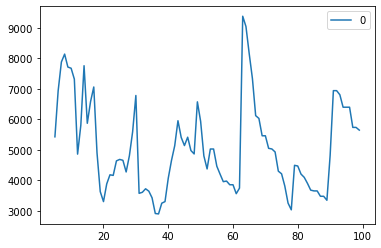

In [20]:
data = getData('AAPL')
results = []
for i in range(5,100):
    data = addSignal(data,fast=5, slow=20, rsi_q=i, buy_cr=1, buy_rsi=55, sell_cr=0.98, sell_rsi=45)
    trades = getTrades(data)
    yields = getYields(trades)
    resultado = float((yields.iloc[-1:].yield_cum-1)*100)
    results.append(resultado)
    
df = pd.DataFrame(results, index=range(5,100))
df.plot()

In [21]:
df.idxmax()

0    63
dtype: int64

## Sensibilidad del RSI señal compra

[*********************100%***********************]  1 of 1 downloaded


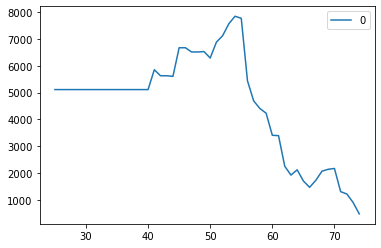

In [22]:
data = getData('AAPL')
results = []
for i in range(25,75):
    data = addSignal(data,fast=5, slow=20, rsi_q=14, buy_cr=1, buy_rsi=i, sell_cr=0.98, sell_rsi=45)
    trades = getTrades(data)
    yields = getYields(trades)
    resultado = float((yields.iloc[-1:].yield_cum-1)*100)
    results.append(resultado)
    
df = pd.DataFrame(results, index=range(25,75))
df.plot()

In [23]:
df.idxmax()

0    54
dtype: int64

## Sensibilidad por montecarlo multivariable

In [24]:
import random
data = getData('AAPL')

[*********************100%***********************]  1 of 1 downloaded


In [25]:
%%time
results = []
for i in range(1000):
    random_f = random.randrange(5,100)
    random_s = int(random_f * (random.random()+1))+1
    random_rsi = random.randrange(5,50)

    data = addSignal(data,fast=random_f, slow=random_s, rsi_q=random_rsi, buy_cr=1, buy_rsi=i, sell_cr=0.98, sell_rsi=45)
    trades = getTrades(data)
    yields = getYields(trades)
    
    try:
        resultado = float((yields.iloc[-1:].yield_cum-1)*100)
        agg_t = yields.groupby('ok').sum()['days']
        time_in = agg_t[True] / (agg_t[True] + agg_t[False]) 
        
    except:
        resultado = 0
        time_in = 0
        
    r = {'resultado':resultado, 'fast':random_f, 'slow':random_s, 'rsi_q':random_rsi, 
         'cant_trades':len(trades), 'time_in':time_in}
    results.append(r)
    
df = pd.DataFrame(results)
df

Wall time: 27.7 s


,resultado,fast,slow,rsi_q,cant_trades,time_in
0,724.647141,78,100,8,54,0.773941
1,2883.816381,56,103,49,28,0.886659
2,4491.084880,6,8,36,120,0.858437
3,4523.880157,82,161,30,14,0.946158
4,1945.547877,81,122,15,34,0.865430
...,...,...,...,...,...,...
995,0.000000,37,47,42,0,0.000000
996,0.000000,22,28,38,0,0.000000
997,0.000000,27,43,48,0,0.000000
998,0.000000,65,129,23,0,0.000000


In [26]:
df.sort_values('resultado')

,resultado,fast,slow,rsi_q,cant_trades,time_in
499,0.000000,53,67,21,0,0.000000
658,0.000000,31,44,20,0,0.000000
659,0.000000,34,45,24,0,0.000000
660,0.000000,39,50,34,0,0.000000
661,0.000000,76,87,12,0,0.000000
...,...,...,...,...,...,...
57,9252.696338,10,16,47,24,0.906396
22,10463.893708,5,9,49,96,0.854752
25,11520.145268,47,61,9,76,0.916059
39,11720.498025,48,66,28,48,0.920971


# Analisis de Portabilidad Básico

In [27]:
results = []
for ticker in sp500_tickers:
    try:
        data = df_sp500[ticker].copy()
        df = addSignal(data,fast=5, slow=20, rsi_q=14, buy_cr=1, buy_rsi=70, sell_cr=0.98, sell_rsi=35)
        trades = getTrades(df)
        yields = getYields(trades)
        resultado = float((yields.iloc[-1:].yield_cum-1)*100)
        results.append({'ticker':ticker, 'resultado':resultado})
        print(ticker, end='..')
    except:
        s = "\n"+ "*"*50 + "\n"
        print(s,"Error con",ticker,s)

results_df = pd.DataFrame(results)
results_df

MMM..ABT..ABBV..ABMD..ACN..ATVI..ADBE..AMD..AAP..AES..AFL..A..APD..AKAM..ALK..ALB..ARE..ALXN..ALGN..ALLE..LNT..ALL..GOOGL..GOOG..MO..AMZN..AMCR..AEE..AAL..AEP..AXP..AIG..AMT..AWK..AMP..ABC..AME..AMGN..APH..ADI..ANSS..ANTM..AON..AOS..APA..AIV..AAPL..AMAT..APTV..ADM..ANET..AJG..AIZ..T..ATO..ADSK..ADP..AZO..AVB..AVY..BKR..BLL..BAC..BK..BAX..BDX..BBY..BIO..BIIB..BLK..BA..BKNG..BWA..BXP..BSX..BMY..AVGO..BR..CHRW..COG..CDNS..CPB..COF..CAH..KMX..CCL..
**************************************************
 Error con CARR 
**************************************************

CAT..CBOE..CBRE..CDW..CE..CNC..
**************************************************
 Error con CNP 
**************************************************

CTL..CERN..CF..SCHW..CHTR..CVX..CMG..CB..CHD..CI..CINF..CTAS..CSCO..C..CFG..CTXS..CLX..CME..CMS..KO..CTSH..CL..CMCSA..CMA..CAG..CXO..COP..ED..STZ..COO..CPRT..GLW..CTVA..COST..COTY..CCI..CSX..CMI..CVS..DHI..DHR..DRI..DVA..DE..DAL..XRAY..DVN..DXCM..FANG..DLR..DFS..DISCA..DISCK..DIS

,ticker,resultado
0,MMM,36.155078
1,ABT,42.269408
2,ABBV,72.515507
3,ABMD,677.148100
4,ACN,95.967858
...,...,...
492,YUM,195.851497
493,ZBRA,29.416244
494,ZBH,241.184694
495,ZION,-54.446173


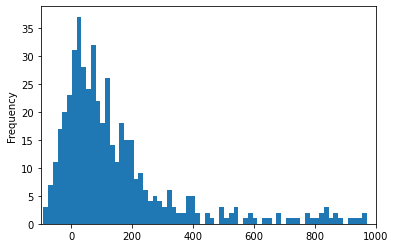

In [36]:
results_df.resultado.plot(kind='hist', bins=1000, xlim=(-100,1000))

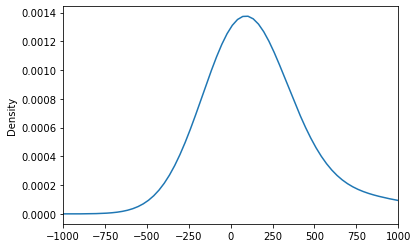

In [44]:
results_df.resultado.plot(kind='kde', xlim=(-1000,1000))